# 01 Data Exploration

- Author: Erik Buunk
- Date: 2020-07-26
- Version: 0.5

Changes:
- 0.4: excl. Pop
- 0.4a: Colab version
- 0.5: include metal

The purpose of this note book to get acquinted with the data to know which operations were needed for the final dataset. 
Also a basline performance was done, from which further development of the model was determined.


## Data files:
- metal_songs.csv
- artist-data.csv
- lyrics-data.csv

## Settings:
- set `COLAB = True` if you run this on Colab. Data can be placed in the root directory

TODO: version requirements

In [1]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
from numpy import log, mean, matmul


required = {'spacy', 'scikit-learn', 'numpy', 
            'pandas', 'torch', 'matplotlib',
            'transformers', 'allennlp==0.9.0'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
import spacy
import numpy as np
import pandas as pd

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Spacy
from spacy.lang.en import English
en = English()

# !python -m spacy download en_core_web_md # includes GloVe Vectors
# !python -m spacy download en_core_web_sm
# !python -m spacy download en

# import en_core_web_sm
# import en_core_web_md


# PyTorch
import torch
# import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



# File managment
import os
from os import listdir
from pathlib import Path
import pickle
import gzip


In [2]:
LOAD_DATA = False # read save data or regenerate data
SAVE_DATA = False # overwrite generated data? 

COLAB = False

In [5]:
if COLAB:
  # Google Colab
  path = "./"
  device = torch.device("cuda:0") # use GPU, change 
else:
  # Laptop
  path = "./data/"
  device = torch.device("cpu")
#   !pip install ipywidgets
#   !jupyter nbextension enable --py widgetsnbextension


# Functions

In [6]:
def show_data():
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          print(os.path.join(dirname, filename))

# show_data()

In [7]:
def save_pickle(filename, data):
    with open(f"{path}{filename}", "wb") as fp: 
      pickle.dump(data, fp)

def load_pickle(filename):
    with open(f"{path}{filename}", 'rb') as f:
      return pickle.load(f)
    
def save_file(filename, train_tokens, test_tokens, val_tokens):
  data = {"train_tokens": train_tokens, "test_tokens" : test_tokens, "val_tokens": val_tokens}

  with open(f"{path}{filename}", "wb") as fp: 
    pickle.dump(data, fp)
    
def load_file(filename):
  with open(f"{path}{filename}", 'rb') as f:
      all_text = pickle.load(f)
      return (all_text["train_tokens"], all_text["test_tokens"], all_text["val_tokens"])


In [8]:
def split_train_val_test (X, y, pct_train = 0.7, pct_val = 0.3):
  np.random.seed(0)
  train_bool = np.random.random(len(X)) <= pct_train
  x_train = X[train_bool]
  y_train = y[train_bool]

  x_test = X[~train_bool]
  y_test = y[~train_bool]

  # split the training 30% for validation
  val_bool = np.random.random(size=len(x_train)) <= pct_val
  x_val = x_train[val_bool]
  y_val = y_train[val_bool]

  # exclude validation from training
  x_train = x_train[~val_bool]
  y_train = y_train[~val_bool]
  
  #check lengths
  print("Training: ", len(x_train), len(y_train))
  print("Validation: ", len(x_val), len(y_val))
  print("Test: ", len(x_test), len(y_test))
  
  return x_train, y_train, x_val, y_val, x_test, y_test

# Load Data

In [9]:
if LOAD_DATA:
  df_total = pd.read_csv(f'{path}df_total.csv')
  df_small = pd.read_pickle(f'{path}df_small.pkl.gz')
  (x_test, x_val, x_test, y_train, y_val, y_test) = load_pickle('data_split_sm.pkl') # based on the sampled small data set

  lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
  lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
  lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

  
# TODO: part of the data preparation can be skipped here of the data is pre-loaded

In [15]:
# Read data
df_artist =  pd.read_csv(f'{path}artists-data.csv')

In [16]:
df_lyrics = pd.read_csv(f'{path}lyrics-data.csv')

In [17]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')

# Data exploration and data preparation
- [x] Check distribution of the data. (genres, artists, lyrics, languages)
- [x] Data analysis: is the data usable, what needs to be cleaned. Visual inspection.
- [ ] Top words, word counts leading to a basic tokenizer.
- [x] Cosine similarity between document genres. 
- [ ] Create a base pipeline, word counts/TFIDF
- [ ] Visualizations


In [18]:
print(df_artist.columns)
print(df_lyrics.columns)
print(df_metal.columns)

Index(['Artist', 'Songs', 'Popularity', 'Link', 'Genre', 'Genres'], dtype='object')
Index(['ALink', 'SName', 'SLink', 'Lyric', 'Idiom'], dtype='object')
Index(['Unnamed: 0', 'Genre', 'Artist', 'Song', 'Lyric'], dtype='object')


#### Lyrics

In [19]:
df_lyrics.shape

(209522, 5)

In [25]:
df_lyrics["Idiom"].value_counts().head(n=10)

ENGLISH        114723
PORTUGUESE      85085
SPANISH          4812
ITALIAN           626
FRENCH            471
GERMAN            314
KINYARWANDA        88
ICELANDIC          47
SWEDISH            27
FINNISH            24
Name: Idiom, dtype: int64

For this project we will use English only.

In [21]:
df_lyrics_en = df_lyrics.query("Idiom == 'ENGLISH'")
df_lyrics_en = df_lyrics_en.drop(["SLink", "Idiom"], axis=1)
df_lyrics_en.shape

(114723, 3)

In [22]:
df_lyrics_en

,ALink,SName,Lyric
0,/10000-maniacs/,More Than This,I could feel at the time. There was no way of ...
1,/10000-maniacs/,Because The Night,"Take me now, baby, here as I am. Hold me close..."
2,/10000-maniacs/,These Are Days,These are. These are days you'll remember. Nev...
3,/10000-maniacs/,A Campfire Song,"A lie to say, ""O my mountain has coal veins an..."
4,/10000-maniacs/,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...
...,...,...,...
207619,/sambo/,This Love,I was so high I did not recognize. The fire bu...
207624,/sambo/,Valerie,Well sometimes I go out by myself. And I look ...
207628,/sambo/,Wake Me Up,Feeling my way through the darkness. Guided by...
207792,/seu-jorge/,Don't,"Don't, don't, that's what you say. Each time t..."


#### Artist

In [36]:
# origianl query:
df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Pop' | Genre == 'Hip Hop'")

# 2 category:
# df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Hip Hop'")

total = df_artist_sm.shape[0]
100*df_artist_sm["Genre"].value_counts()/total

Rock       37.417840
Pop        37.370892
Hip Hop    25.211268
Name: Genre, dtype: float64

In [117]:
# original
genres = ["Rock", "Pop", "Hip Hop"]

# 2 category
# genres = ["Rock", "Hip Hop", "Metal"]
genres.sort()

total_songs = df_artist_sm["Songs"].sum()
print(f"Total Songs: {total_songs}")
for i in genres:
    percentage = round(100*df_artist_sm[df_artist_sm.Genre == i]["Songs"].sum()/total_songs, 2 )
    print(f"{i} {percentage}%")

Total Songs: 127523
Hip Hop 17.03%
Pop 34.15%
Rock 48.82%


In [118]:
df_artist_sm_red = df_artist_sm.drop(["Genres", "Popularity", "Songs"], axis = 1)

In [119]:
df_artist_sm_red

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock
1,12 Stones,/12-stones/,Rock
2,311,/311/,Rock
3,4 Non Blondes,/4-non-blondes/,Rock
4,A Cruz Está Vazia,/a-cruz-esta-vazia/,Rock
...,...,...,...
3227,Tati Quebra Barraco,/tati-quebra-barraco/,Hip Hop
3228,Valesca Popozuda,/valesca-popozuda/,Pop
3229,Vine Rodry,/vine-rodry/,Pop
3234,Leandro Sapucahy,/leandro-sapucahy/,Pop


In [120]:
# Remove duplicate Link values

# pd.DataFrame(df_artist_sm["Link"].value_counts())
(df_artist_sm_red["Link"].value_counts() > 1).sum()

144

In [121]:
# drop duplicates
df_artist_dedup = df_artist_sm_red.drop(df_artist_sm_red[df_artist_sm_red.Link.duplicated()].index)

In [122]:
# Some artist have multiple genrese. These are removed.

(df_artist_dedup["Link"].value_counts() > 1).sum()
df_artist_dedup[df_artist_dedup["Artist"] =='10000 Maniacs']

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock


#### Metal lyrics

In [123]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')
df_metal.head()

,Unnamed: 0,Genre,Artist,Song,Lyric
0,0,Metal,QUANTICE NEVER CRASHED,Any Port In The Storm,Instrumental
1,1,Metal,QUANTICE NEVER CRASHED,Pins And Needles,Picture a parade of mannequins ivory white S...
2,2,Metal,QUANTICE NEVER CRASHED,Shaolin Casanova,Fuck you I want to know how it feels that I m...
3,3,Metal,QUANTICE NEVER CRASHED,Lighthouses,The ties that bind can gag and I m bound by bo...
4,4,Metal,QUANTICE NEVER CRASHED,Running Man,I ve built walls around me I ve surrounded my...


In [124]:
# drop instrumental songs
df_metal = df_metal[df_metal["Lyric"]!= ' Instrumental   ']
df_metal

,Unnamed: 0,Genre,Artist,Song,Lyric
1,1,Metal,QUANTICE NEVER CRASHED,Pins And Needles,Picture a parade of mannequins ivory white S...
2,2,Metal,QUANTICE NEVER CRASHED,Shaolin Casanova,Fuck you I want to know how it feels that I m...
3,3,Metal,QUANTICE NEVER CRASHED,Lighthouses,The ties that bind can gag and I m bound by bo...
4,4,Metal,QUANTICE NEVER CRASHED,Running Man,I ve built walls around me I ve surrounded my...
5,5,Metal,QUANTICE NEVER CRASHED,Two Bullets And A Gun,I guess I never told you I was never one to g...
...,...,...,...,...,...
49994,49994,Metal,ensiferum,The New Dawn,Through the storm like the wind we ride Leavin...
49996,49996,Metal,ensiferum,Victory Song,The plan of invasion an Evil deception Was mad...
49997,49997,Metal,ensiferum,Lady In Black,originally by Uriah Heep She came to me one m...
49998,49998,Metal,ensiferum,One More Magic Potion,Once when we were returning from a battle and ...


In [125]:
df_metal = df_metal[~df_metal["Lyric"].isnull()]

In [126]:
l = df_metal["Lyric"].apply(lambda x: x.strip())
l

1        Picture a parade of mannequins  ivory white  S...
2        Fuck you  I want to know how it feels that I m...
3        The ties that bind can gag and I m bound by bo...
4        I ve built walls around me  I ve surrounded my...
5        I guess I never told you  I was never one to g...
                               ...                        
49994    Through the storm like the wind we ride Leavin...
49996    The plan of invasion an Evil deception Was mad...
49997    originally by Uriah Heep She came to me one mo...
49998    Once when we were returning from a battle and ...
49999    In time bleeding wounds will heal Unlike some ...
Name: Lyric, Length: 49276, dtype: object

In [127]:
df_metal = df_metal[l!='']

In [128]:
df_metal2 = pd.DataFrame({"SName" : df_metal["Song"],	
                          "Lyric": df_metal["Lyric"],  	
                          "Artist" : df_metal["Artist"],  	
                          "Genre": df_metal["Genre"]})
                         
                       
                         
df_metal2                         

,SName,Lyric,Artist,Genre
1,Pins And Needles,Picture a parade of mannequins ivory white S...,QUANTICE NEVER CRASHED,Metal
2,Shaolin Casanova,Fuck you I want to know how it feels that I m...,QUANTICE NEVER CRASHED,Metal
3,Lighthouses,The ties that bind can gag and I m bound by bo...,QUANTICE NEVER CRASHED,Metal
4,Running Man,I ve built walls around me I ve surrounded my...,QUANTICE NEVER CRASHED,Metal
5,Two Bullets And A Gun,I guess I never told you I was never one to g...,QUANTICE NEVER CRASHED,Metal
...,...,...,...,...
49994,The New Dawn,Through the storm like the wind we ride Leavin...,ensiferum,Metal
49996,Victory Song,The plan of invasion an Evil deception Was mad...,ensiferum,Metal
49997,Lady In Black,originally by Uriah Heep She came to me one m...,ensiferum,Metal
49998,One More Magic Potion,Once when we were returning from a battle and ...,ensiferum,Metal


#### Join the data

In [129]:
# join the two data frames
df_lyrics_prejoin = df_lyrics_en.set_index('ALink')
df_artist_prejoin = df_artist_dedup.set_index('Link')
df_total = df_lyrics_prejoin.join(df_artist_prejoin)

In [130]:
# check that the join is correct
df_total.shape

(114723, 4)

In [131]:
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock
/10000-maniacs/,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock
/10000-maniacs/,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock
/10000-maniacs/,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",10000 Maniacs,Rock
/10000-maniacs/,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,Whiskey'n Mama,"I'm so tired, you on my head.. Whiskey'n mama,...",ZZ Top,Rock
/zz-top/,Woke Up With Wood,When I woke up this morning. I was feeling mig...,ZZ Top,Rock
/zz-top/,World of Swirl,"I hit the street running, had an angle in mind...",ZZ Top,Rock
/zz-top/,Your Legs Are As Hairy As My Beard,I've got a beard. And it is long. And you've g...,ZZ Top,Rock


In [132]:
# drop na values that couldn't be matched
df_total = df_total[~df_total["Genre"].isnull()]
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock
/10000-maniacs/,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock
/10000-maniacs/,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock
/10000-maniacs/,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",10000 Maniacs,Rock
/10000-maniacs/,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,Whiskey'n Mama,"I'm so tired, you on my head.. Whiskey'n mama,...",ZZ Top,Rock
/zz-top/,Woke Up With Wood,When I woke up this morning. I was feeling mig...,ZZ Top,Rock
/zz-top/,World of Swirl,"I hit the street running, had an angle in mind...",ZZ Top,Rock
/zz-top/,Your Legs Are As Hairy As My Beard,I've got a beard. And it is long. And you've g...,ZZ Top,Rock


In [133]:
# add metal dataset
df_total = df_total.append(df_metal2, ignore_index=True)
df_total

,SName,Lyric,Artist,Genre
0,More Than This,I could feel at the time. There was no way of ...,10000 Maniacs,Rock
1,Because The Night,"Take me now, baby, here as I am. Hold me close...",10000 Maniacs,Rock
2,These Are Days,These are. These are days you'll remember. Nev...,10000 Maniacs,Rock
3,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",10000 Maniacs,Rock
4,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,10000 Maniacs,Rock
...,...,...,...,...
155478,The New Dawn,Through the storm like the wind we ride Leavin...,ensiferum,Metal
155479,Victory Song,The plan of invasion an Evil deception Was mad...,ensiferum,Metal
155480,Lady In Black,originally by Uriah Heep She came to me one m...,ensiferum,Metal
155481,One More Magic Potion,Once when we were returning from a battle and ...,ensiferum,Metal


In [134]:
#TODO: Sort by Genre so we know the splits in the data for cosine similarities
df_total = df_total.sort_values(ascending=True, by="Genre")
df_total = df_total.reset_index()
df_total = df_total.drop(["index"], axis=1)

In [135]:
df_total

,SName,Lyric,Artist,Genre
0,Right For Me,"I got plans tonight. And you, you know what I ...",Justin Timberlake,Hip Hop
1,King of New York,[Saya]. An' bamba clad boy feel dem bobbin try...,Fat Joe,Hip Hop
2,Lean Back,Yeah... My niggas.... Throw ya hands in the ai...,Fat Joe,Hip Hop
3,"Lean Back (remix) Featuring Lil Jon, Eminem",[Intro - Lil Jon]. Stop! It's the mothafuckin ...,Fat Joe,Hip Hop
4,Life Goes On,"[Intro - Fat Joe talking]. Yeah, uh, yeah, Loy...",Fat Joe,Hip Hop
...,...,...,...,...
155478,One Big Holiday,"wakin' up, feelin' good & limber. when the tel...",My Morning Jacket,Rock
155479,One In The Same,On the way back home.... How long did it seem?...,My Morning Jacket,Rock
155480,Only Memories Remain,Only memories remain. Only memories remain. Fo...,My Morning Jacket,Rock
155481,I Will Be There When You Die,"joe was born in new york city, son of paul and...",My Morning Jacket,Rock


In [136]:
df_total["Genre"].value_counts()

Rock       55802
Metal      45998
Pop        34974
Hip Hop    18709
Name: Genre, dtype: int64

In [137]:
# text = ["Hello [CHORUS] and then more (repeat 2x)", "Another text [intro] and [Repeat]", "THis is just text"]
# text

In [138]:
# df_total_bak = df_total

In [139]:
# df_total = df_total_bak
# df_total.drop(["Lyrics_cleaned"], axis=1)

In [140]:
df_total

,SName,Lyric,Artist,Genre
0,Right For Me,"I got plans tonight. And you, you know what I ...",Justin Timberlake,Hip Hop
1,King of New York,[Saya]. An' bamba clad boy feel dem bobbin try...,Fat Joe,Hip Hop
2,Lean Back,Yeah... My niggas.... Throw ya hands in the ai...,Fat Joe,Hip Hop
3,"Lean Back (remix) Featuring Lil Jon, Eminem",[Intro - Lil Jon]. Stop! It's the mothafuckin ...,Fat Joe,Hip Hop
4,Life Goes On,"[Intro - Fat Joe talking]. Yeah, uh, yeah, Loy...",Fat Joe,Hip Hop
...,...,...,...,...
155478,One Big Holiday,"wakin' up, feelin' good & limber. when the tel...",My Morning Jacket,Rock
155479,One In The Same,On the way back home.... How long did it seem?...,My Morning Jacket,Rock
155480,Only Memories Remain,Only memories remain. Only memories remain. Fo...,My Morning Jacket,Rock
155481,I Will Be There When You Die,"joe was born in new york city, son of paul and...",My Morning Jacket,Rock


**This is the dataset that I will be using Below**

Create ranges for the different genres

In [141]:
# original
# genres = ["Rock", "Pop", "Hip Hop"]

count = 0
start = 0
ranges = []
for g in genres:
  total_in_genre = len(df_total[df_total["Genre"] == g])
  count += total_in_genre
  ranges.append((start, count))
  start = count
print(genres)
print(ranges)

['Hip Hop', 'Pop', 'Rock']
[(0, 18709), (18709, 53683), (53683, 109485)]


In [142]:
# if LOAD_DATA:
#   df_total = pd.read_csv(f'{path}df_total.csv')

# if SAVE_DATA:
#   df_total.to_csv(f'{path}df_total.csv')

Simplify the data structure
- y: y["Lyrics"] # predictor variable
- X: X["Genre"] # outcome

In [143]:
def simplify_data(data):
  y = data["Genre"]
  y = y.reset_index()
  y = y.drop('index', axis=1)
  
  X= data["Lyric"]
  X = X.reset_index()
  X = X.drop("index", axis=1)
  return (X,y)



In [144]:
X, y = simplify_data(df_total)


In [145]:
print(len(X))
X[0:2]


155483


,Lyric
0,"I got plans tonight. And you, you know what I ..."
1,[Saya]. An' bamba clad boy feel dem bobbin try...


In [146]:
print(len(y))
y[0:2]

155483


,Genre
0,Hip Hop
1,Hip Hop


## Top words
Get the top word of the whole data set. This will help in the cleanup and the fine tuning of the tokenizer. 

In [147]:
# Use the default tokenizer
cv = CountVectorizer(lowercase=True, max_df=0.98, min_df=0.01, stop_words='english')
# cv = CountVectorizer(tokenizer=lyric_tokenizer, lowercase=True, max_df=0.98, min_df=0.01)

word_count_vecs = cv.fit_transform(X["Lyric"]).toarray()

# get_feature_names gets the vocabulary of the vectorizer in order
word_count = dict(zip(cv.get_feature_names(), word_count_vecs.sum(axis=0)))

In [148]:
# get the top n words
sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:30]

[('don', 238518),
 ('like', 222077),
 ('know', 218528),
 ('love', 201245),
 ('just', 187794),
 ('oh', 167264),
 ('got', 159428),
 ('ll', 151732),
 ('let', 124327),
 ('time', 121093),
 ('yeah', 112382),
 ('baby', 110821),
 ('ve', 103504),
 ('want', 100032),
 ('come', 98223),
 ('make', 94603),
 ('say', 93307),
 ('cause', 91882),
 ('way', 91530),
 ('life', 86873),
 ('wanna', 84403),
 ('feel', 79324),
 ('gonna', 71830),
 ('right', 71349),
 ('ain', 71162),
 ('away', 71130),
 ('girl', 70623),
 ('need', 70167),
 ('tell', 64221),
 ('night', 63491)]

default tokenizer: Comon word word: don('t), like, know, love, just, oh, 'll, yeah, baby, time, wnat, 've, cause, say. (no min_df, max_df, excl sto pwords)
max_df: very common word
min_df: very uncommon


[('don', 218634),
 ('like', 204500),
 ('know', 200799),
 ('love', 189709),
 ('just', 169860),
 ('oh', 158864),
 ('got', 152153),
 ('ll', 129728),
 ('let', 111768),
 ('yeah', 109196),
 ('baby', 108733),
 ('time', 98020),
 ('want', 91574),
 ('ve', 86794),
 ('cause', 86522),
 ('say', 86175),
 ('make', 85829),
 ('come', 84710),
 ('wanna', 81118),


lyric tokenizier
[('know', 228895),
 ('get', 210308),
 ('like', 206918),
 ('love', 206528),
 ('oh', 157188),
 ('go', 142213),
 ('come', 128330),
 ('yes', 120515),
 ('let', 116793),
 ('time', 110263),
 ('baby', 108838),
 ('want', 107840),
 ('to', 104806),
 ('feel', 101086),
 ('be', 89481),
 ('girl', 84078),
 ('way', 82183),
 ('wanna', 81094),
 ('tell', 79401),
 ('think', 74498)]
 

# Initial Setup

## Visual inspection of the data

From visual inspection of the data:

- text and chords between square bracket, [CHORUS], [Dm], [50 Cent]. etc:  greedy: `\[.*?\]` (better for purpose (non greedy: `\[.*\]` and `\(.*\)` )
- manu times thing between regular brackets will be additional no lyrics info. In other cases it can be the second voice line or background singers.
- words: CHORUS, REPEAT, verse, bridge ['chorus', ] 
- 2x: \dx
- chords: E B (single character, Em, Dm A7

TABS, digits and non alpha numerical characters
```
+-------------------------------------------------------------------
+-------------------------------------------------------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------5---5---5---5-----4--4--4--4--4--4----------------------
+-------------------------------------------------------------------
```

Comments:
```
Denis
edj1234@bosoleil.ci.umoncton.ca
Certain parts of the solos may be incorrectly transcribed, but they
should be in the right key anyway. Make amends where you see fit.
1st solo(w/wah,distortion)-
```

Will be hard to remove. URL and email should be removed. 


Whole instructions:
```
Duration Legend
---------------
W - whole
H - half
Q - quarter
E - 8th
S - 16th
T - 32nd
X - 64th
. - note dotted
|-n-| - n-tuplets
Tablature Legend
----------------
L - tied note
x - dead note
g - grace note
(n) - ghost note
> - accentuded note
NH - natural harmonic
AH - artificial harmonic
TH - tapped harmonic
SH - semi harmonic
PH - pitch harmonic
h - hammer on
p - pull off
b - bend
br - bendRelease
pb - preBend
(...)
```

- Sometimes artist names appear in the lyrics. If it is actually in the lyrics this is OK (some artist say their name a lot in songs), but in the case of featuring XXX, this give may give hints away. As well with text such as `(Skid Row Cover)`

### Split into test/train/validation

In [149]:
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X, y)

Training:  76120 76120
Validation:  32607 32607
Test:  46756 46756


### Tokenizer

In [150]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_ for t in parsed if (t.is_alpha)])
    

In [151]:

# TODO: clean up, not used right now
# filename = "tokens.pkl"

# my_file = Path(f"{path}{filename}")

# if LOAD_DATA and my_file.is_file():
#   print("loading file")
#   (train_tokens, test_tokens, val_tokens) = load_file(filename)
# else:
#   print("generating tokens")
#   train_tokens =  [simple_tokenizer(x) for x in x_train["Lyric"]]
#   test_tokens =  [simple_tokenizer(x) for x in x_test["Lyric"]]
#   val_tokens = [simple_tokenizer(x) for x in x_val["Lyric"]]
#   if SAVE_DATA:
#     save_file(filename, train_tokens, test_tokens, val_tokens)


In [152]:
# print(len(train_tokens), len(val_tokens), len(test_tokens))

### Word counts

In [153]:
def get_document_vectors(model, train, val, test):
  word_count_vecs_train = model.fit_transform(list(train["Lyric"])).toarray()
  word_count_vecs_val = model.transform(list(val["Lyric"])).toarray()
  word_count_vecs_test = model.transform(list(test["Lyric"])).toarray()
  
  return (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [154]:
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True, max_df=0.99, min_df=0.01)

(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

# get_feature_names gets the vocabulary of the vectorizer in order
word_count_train = dict(zip(cv.get_feature_names(), word_count_vecs_train.sum(axis=0)))
# word_count_val = dict(zip(cv.get_feature_names(), word_count_vecs_val.sum(axis=0)))
# word_count_test = dict(zip(cv.get_feature_names(), word_count_vecs_test.sum(axis=0)))


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [155]:
word_count_train_df = pd.DataFrame(word_count_vecs_train, columns=cv.get_feature_names())

word_count_train_df

,-PRON-,2,act,action,afraid,age,ago,ah,ahead,air,...,write,wrong,y,yea,year,yes,yesterday,yo,young,﻿1
0,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,1,1,0
1,5,0,1,0,1,0,0,0,0,0,...,0,3,0,0,0,7,0,3,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,0,2,0,0
3,40,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,5,0,0
4,11,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76116,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76117,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,11,0,0,0,0
76118,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
vocab = cv.vocabulary_


### Cosine similarities

In [157]:
# get similarities

# We cannot get the similarity matrix for the whole matrix so we need to break it into smaller pieces:
# count_sims = cosine_similarity(count_vecs) # nnz of the result is too large

file_name = "cosine_data.pkl"

my_file = Path(f"{path}{file_name}")

if LOAD_DATA and my_file.is_file():
  cosine_data = load_pickle(file_name)
else:
  cosine_data = []
  for i in range(0,len(genres)):
    for j in range(i,len(genres)):
      print(f"{genres[i]} - {genres[j]}")
      cosim = cosine_similarity(word_count_vecs_train[ranges[i][0]:ranges[i][1]], word_count_vecs_train[ranges[j][0]:ranges[j][1]]).mean(axis=1).mean()
      print(cosim)
      cosine_data.append([f"{genres[i]} - {genres[j]}", cosim])
  if SAVE_DATA:
    save_pickle(file_name, cosine_data)
  
  
print(cosine_data)

Hip Hop - Hip Hop
0.12081271048574312
Hip Hop - Pop
0.11799596258407674
Hip Hop - Rock
0.13739299789576961
Pop - Pop
0.12384269144729153
Pop - Rock
0.1492059161760659
Rock - Rock
0.19480680428323668
[['Hip Hop - Hip Hop', 0.12081271048574312], ['Hip Hop - Pop', 0.11799596258407674], ['Hip Hop - Rock', 0.13739299789576961], ['Pop - Pop', 0.12384269144729153], ['Pop - Rock', 0.1492059161760659], ['Rock - Rock', 0.19480680428323668]]


Cosine similarities with CountVectorizer.

Within genre similarities: between .19 and .24. Hip hop is the most similar
```

Hip Hop - Hip Hop
0.24765970212980423
Rock - Rock
0.2110855129121092
Pop - Pop
0.1913122770773068

```

Between genre: .19, .21 so not a lot of difference with the within genre
```
Hip Hop - Pop
0.21271535384634718
Hip Hop - Rock
0.21665027671484652
Pop - Hip Hop
0.21271535384634724
Pop - Rock
0.19618950933884402
Rock - Hip Hop
0.21665027671484652
Rock - Pop
0.196189509338844
```

Only Hip Hop lyrics seem to be a bit more similar.

### Topic Modeller

In [158]:
# choose the number of components (topics) -> you choose the number of topics. (UB)
def train_topic_modeller(train_vecs, val_vec, test_vecs, n_components = 10, type = "NMF"):
  
  # set topic modeller
  if type == 'NMF': 
    tm = NMF(n_components=n_components)
  else:
    tm = LatentDirichletAllocation(n_components=n_components)

  # same syntax as vectorizer
  tm_train_vecs = tm.fit_transform(train_vecs)
  tm_val_vecs = tm.transform(val_vec)
  tm_test_vecs = tm.transform(test_vecs)
  return (tm, tm_train_vecs, tm_val_vecs, tm_test_vecs)

(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [159]:
print(nmf_train_vecs.shape) # 2711x10topic
print(nmf.components_.shape) # 10x239 words 

(76120, 10)
(10, 925)


In [160]:
def display_components(model, word_features, top_display=10):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("\tTopic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print("\t"+", ".join(top_words))

In [162]:
display_components(nmf, cv.get_feature_names())

	Topic 0:
	-PRON-, just, think, say, make, time, cause, look, tell, way
	Topic 1:
	oh, ooh, ah, whoa, night, da, uh, feel, good, body
	Topic 2:
	love, heart, feel, need, make, fall, way, say, want, like
	Topic 3:
	come, just, let, time, make, s, say, feel, life, way
	Topic 4:
	la, da, say, que, y, n, sing, el, en, wanna
	Topic 5:
	na, come, hey, -PRON-, make, ha, work, n, lord, right
	Topic 6:
	like, nigga, bitch, fuck, shit, girl, money, niggas, make, feel
	Topic 7:
	yes, say, good, hey, make, ooh, wanna, right, need, come
	Topic 8:
	know, want, say, tell, just, wanna, think, need, thing, really
	Topic 9:
	baby, girl, wanna, want, let, just, make, need, right, come


### Initial Prediction Performance

In [163]:
def train_SVC(x,y,x_val, y_val):
  svc_nmf = LinearSVC(max_iter=2000)
  svc_nmf.fit(x, y)

#   save_pickle(file_name='svc_nmf.pkl', data=svc_nmf)
  # run model on validation
  val_preds = svc_nmf.predict(x_val)
  acc = accuracy_score(y_val, val_preds)
  print(f"Accuracy: {round(acc,2)}")
  return acc

In [164]:
# Basic accuracy with 
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.65


0.6471003158830926

#### 3 genres (Pop, Rock, Hip Hop)

So apart form the baseline (random pick, or alway choose 'Rock'). The model predict 60% correct on the validation set. No so good but that's the baseline for now.


#### 2 genres (Rock, Hip Hop)
About 75% percent of the lyrics are Rock, so the base line is 75% accuracy in this case. With the topic modeller we have 87% accuracy. Which is better, so still not very good.


#### 3 genres (Rock, Hip Hop, Metal)
82%. So this is going in the right direction

# Optimizing the current performance - Feature creation


To make the project workable (either on a local machine or on google colab), I will use a subset of the data to do the project with

### Cleaning up

In [165]:
# remove the tabs from the corpus
sub ='(tablatura)'
indexes_to_drop = df_total[df_total["SName"].str.find(sub) != -1].index
len(df_total)

155483

In [166]:
df_total = df_total.drop(indexes_to_drop, axis=0)
len(df_total)

155315

In [167]:
df_total

,SName,Lyric,Artist,Genre
0,Right For Me,"I got plans tonight. And you, you know what I ...",Justin Timberlake,Hip Hop
1,King of New York,[Saya]. An' bamba clad boy feel dem bobbin try...,Fat Joe,Hip Hop
2,Lean Back,Yeah... My niggas.... Throw ya hands in the ai...,Fat Joe,Hip Hop
3,"Lean Back (remix) Featuring Lil Jon, Eminem",[Intro - Lil Jon]. Stop! It's the mothafuckin ...,Fat Joe,Hip Hop
4,Life Goes On,"[Intro - Fat Joe talking]. Yeah, uh, yeah, Loy...",Fat Joe,Hip Hop
...,...,...,...,...
155478,One Big Holiday,"wakin' up, feelin' good & limber. when the tel...",My Morning Jacket,Rock
155479,One In The Same,On the way back home.... How long did it seem?...,My Morning Jacket,Rock
155480,Only Memories Remain,Only memories remain. Only memories remain. Fo...,My Morning Jacket,Rock
155481,I Will Be There When You Die,"joe was born in new york city, son of paul and...",My Morning Jacket,Rock


### Smaller data set
Because the dataset is very large, a sub selection will be used for the further proces. Using the full corpus was not possibel in all all case (calculation times and memory constraints). 

We choose a split of 10000 lyrics. Then we have  training/validation of about 5000 training, 2000 validation and 3000 test.

In [168]:
if LOAD_DATA:
  df_small = pd.read_pickle('df_small.pkl.gz')
else:
  df_small = df_total.sample(n=10000,replace="False", random_state=17)
  if SAVE_DATA:
    df_small.to_csv(f"{path}df_small.csv")

df_small

,SName,Lyric,Artist,Genre
64845,Blueberry Pies,Lying is killing the good things in me. Ask me...,Prefab Sprout,Pop
34990,Cathedral,I used to be so tough From times to times I...,MECHANICAL POET,Metal
42341,Paradise,Searching for someone so long To fill this hol...,IMPELLITTERI,Metal
125803,G.O.D.,I been searchin' for so long. For a love to fi...,Billy Squier,Rock
25643,Elivagar Pakanavedet,Line up Henri Urponpoika Sorvali guitars ...,moonsorrow,Metal
...,...,...,...,...
70772,Bang Bang Bang,what do you go and do. you go and give the boy...,Tracy Chapman,Pop
126815,Across The Sea,You are eighteen year old girl. Who live in sm...,Weezer,Rock
543,"Shining (Feat. Beyoncé, Jay Z)","Yeah, yeah. We The Best Music!. I worked my wh...",DJ Khaled,Hip Hop
9293,Bad Guys Always Die,(Dre). All you see is the sun. Reflecting off ...,Eminem,Hip Hop


In [172]:
X_sm, y_sm = simplify_data(df_small)
y_sm["Genre"].value_counts()


Rock       3580
Metal      2942
Pop        2222
Hip Hop    1256
Name: Genre, dtype: int64

In [173]:
# train/validation/test sets
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X_sm, y_sm)

Training:  4857 4857
Validation:  2171 2171
Test:  2972 2972


In [174]:
# vectors
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "NMF")
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy: 0.67


0.6688162137263933

#### 3 genres:
The results of the smaller set are the same.

#### 2 genres:
Results are a little less: 85%

#### 3 genres:
Results are a little less: 80%

### Optimize the tokenizer:


In [175]:
def lyric_tokenizer(doc):
    model = en # nlp_md takes a lot longer to process and results are the same

    parsed = model(doc)
    tokens = [t.lemma_ for t in parsed if (t.is_alpha) & (not t.is_digit) &  (not t.is_punct) & (not t.like_url) & (not t.like_email) & (not t.is_stop) & (len(t.text)>1)] 
    return tokens

cv = CountVectorizer(tokenizer=lyric_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

In [176]:
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.57


0.5656379548595117

#### 3 genres
So a more specifice tokenizer does not improve the model. Nor  does used a larger model/corpus

#### 2 genres
Small improvement over small baseline (88%)


#### 3 genres
68%. This is doing a lot worse!

#### 4 genres 
57%

### LDA Model

In [177]:
# train LDA topic modeller
(lda, lda_train_vecs, lda_val_vecs, lda_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "LDA")
# display_components(lda, cv.get_feature_names())

# predict
train_SVC(lda_train_vecs, y_train["Genre"], lda_val_vecs, y_val["Genre"])

Accuracy: 0.58


0.5762321510824505

#### 3 Genres
Performance is a little less

#### 2 Genres
Performance is a little less(85% vs 88% of NMF)


#### 3 genres:
72% (LDA with lyrics tokenizer)
80% (LDA with simple tokeninzer)

#### 4 genres: 
58%

### TF-IDF Vectorizer

In [179]:
# # TFIDF
# tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
# (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(tfidf,x_train, x_val, x_test)

# # train topic modeller
# (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# # predict
# train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])


#### 3 genres
62% Again, maybe a little better.

#### 2 genres:
85% a little less than the NMF with regular counts

#### 3 genres
(simple tokenizer)
83%

## Determine the number topics


In [180]:
accuracies = []
c = range (2,20)

for n in c:

  # train topic modeller
  print(f"Number of topics: {n}")
  (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, n_components = n, type = "NMF")
#   display_components(nmf, cv.get_feature_names())

  # predict
  accuracies.append(  train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"]))


Number of topics: 2
Accuracy: 0.58
Number of topics: 3
Accuracy: 0.59
Number of topics: 4
Accuracy: 0.59
Number of topics: 5
Accuracy: 0.59
Number of topics: 6
Accuracy: 0.63
Number of topics: 7
Accuracy: 0.64
Number of topics: 8


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Accuracy: 0.65
Number of topics: 9


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Accuracy: 0.65
Number of topics: 10
Accuracy: 0.66
Number of topics: 11
Accuracy: 0.68
Number of topics: 12
Accuracy: 0.68
Number of topics: 13


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Accuracy: 0.67
Number of topics: 14


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Accuracy: 0.68
Number of topics: 15
Accuracy: 0.68
Number of topics: 16
Accuracy: 0.68
Number of topics: 17
Accuracy: 0.68
Number of topics: 18
Accuracy: 0.68
Number of topics: 19
Accuracy: 0.67


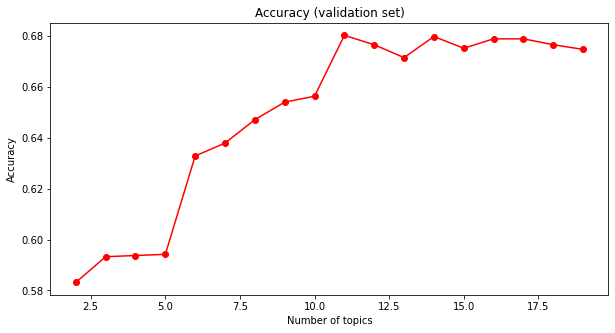

In [181]:
import matplotlib.pyplot as plt

def plot_accuracies(errors, x):
  
  fig, axes = plt.subplots(1,1, figsize=(10,5), sharex=False, sharey=False)
  ax1=axes
  

  
  ax1.plot(x,errors, color='red', marker="o")
  ax1.set_title('Accuracy (validation set)')
  ax1.set_xlabel('Number of topics')
  ax1.set_ylabel('Accuracy')

plot_accuracies(accuracies, list(c))

#### 3 genres
So the number of topics does not really make a difference, Around 8 or 10 topics good enough

#### 2 genres
4 topics is clearly the max that we need for this purpose

#### 3 genres 2 (Metal/Rock/HipHop)
9 topic has the highest accuracy

#### 4 genres
12 topics

## Creating BERT tokens

In [ ]:
import transformers
# what we're used to: BERT
from transformers import BertTokenizer, BertModel 

MODEL_NAME = 'bert-base-uncased'
# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


In [ ]:
# Test script
# %%time
# # one dimension of difference: speed
# samp_lyrics = x_train['Lyric'].iloc[:100]
# tokens = tokenizer.batch_encode_plus(x_train['Lyric'].iloc[:5],
#   pad_to_max_length=True, return_tensors="pt", 
#   max_length=512) # BERT expects sequences of 512 tokens
# outputs = model(**tokens)

In [ ]:

# # start: 
# save_pickle('bert_lyrics_sm.pkl', outputs)
# save_pickle('all_data.pkl', (x_test, x_val, x_test, y_train, y_val, y_test))

# import gzip
# pickle.dump(outputs, gzip.open(f'{path}lyrics_bert_vectors.pkl.gz', 'wb'))

In [ ]:
outputs[0].shape # 5x512x768

In [ ]:
# set the whole model to GPU
model.to(device)

# here we're doing small batches to the model on GPU, we'll load the product of this process later
# The model itself takes up a LOT of memory, so we're passing very small batches
# note here: You may run out of RAM if you try and run this along with all the above.

def generate_BERT_tokens(data, filename):
  
  st = 0
  batch_size = 5
  batches = list(range(batch_size, len(data), batch_size))+[len(data)]
  # print(batches)
  doc_rep_collector = []
  for b in batches:
      tokens = tokenizer.batch_encode_plus(
          data["Lyric"][st:b],
          pad_to_max_length=True, 
          return_tensors="pt",
          max_length=512,
          truncation=True)
      st = b
      tokens.to(device)
      outputs = model(**tokens)
      # taking the representation of the 'CLS' token (doc-level embedding)
      o = outputs[0][:,0].cpu().detach().numpy()
      doc_rep_collector.append(o)

  # stack into array
  doc_rep_collector = np.concatenate(doc_rep_collector)
  
  # to minimize size, can store as 16-bit float
  doc_rep_collector = doc_rep_collector.astype('float16')

  # additionally, will store as gzip (pandas can handle this)
  pickle.dump(doc_rep_collector, gzip.open(f'{path}{filename}', 'wb'))

In [ ]:
%%time
if COLAB:
  generate_BERT_tokens(x_train, 'lyrics_bert_vectors_train.pkl.gz')
  

Laptop:
```
Wall time ~ 2min 40s for 100 records
```

Colab:
```
CPU times: user 1min 55s, sys: 1min 14s, total: 3min 10s
Wall time: 3min 10s
```

In [ ]:
%%time
if COLAB:
  generate_BERT_tokens(x_val, 'lyrics_bert_vectors_val.pkl.gz')




Colab:
```
CPU times: user 52.5 s, sys: 34.1 s, total: 1min 26s
Wall time: 1min 26s,
```

In [ ]:
%%time
if COLAB:
  generate_BERT_tokens(x_test, 'lyrics_bert_vectors_test.pkl.gz')

Colab
```
CPU times: user 1min 11s, sys: 46.8 s, total: 1min 58s
Wall time: 1min 58s
```

In [182]:
# load the BERT tokens
lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

In [183]:
# BERT prediction
train_SVC(lyrics_bert_vectors_train, y_train["Genre"], lyrics_bert_vectors_val, y_val["Genre"])

Accuracy: 0.3


/Users/erikbuunk/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.30446798710271766